# Cross-subject decoding rule representations

#### Takuya Ito
#### 2/28/2018

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import multiprocessing as mp
import scipy.stats as stats
import os
os.environ['OMP_NUM_THREADS'] = str(1)
import statsmodels.sandbox.stats.multicomp as mc
import seaborn as sns
import h5py
import tools_group_rsa as tools_group
import nibabel as nib
tools_group = reload(tools_group)

sns.set_style("whitegrid")
plt.rcParams["font.family"] = "FreeSans"


In [2]:
# Excluding 084
subjNums = ['013','014','016','017','018','021','023','024','026','027','028','030','031','032','033',
            '034','035','037','038','039','040','041','042','043','045','046','047','048','049','050',
            '053','055','056','057','058','062','063','066','067','068','069','070','072','074','075',
            '076','077','081','085','086','087','088','090','092','093','094','095','097','098','099',
            '101','102','103','104','105','106','108','109','110','111','112','114','115','117','119',
            '120','121','122','123','124','125','126','127','128','129','130','131','132','134','135',
            '136','137','138','139','140','141']



basedir = '/projects3/SRActFlow/'

# Using final partition
networkdef = np.loadtxt('/projects3/NetworkDiversity/data/network_partition.txt')
networkorder = np.asarray(sorted(range(len(networkdef)), key=lambda k: networkdef[k]))
networkorder.shape = (len(networkorder),1)
# network mappings for final partition set
networkmappings = {'fpn':7, 'vis1':1, 'vis2':2, 'smn':3, 'aud':8, 'lan':6, 'dan':5, 'con':4, 'dmn':9, 
                   'pmulti':10, 'none1':11, 'none2':12}
networks = networkmappings.keys()

xticks = {}
reorderednetworkaffil = networkdef[networkorder]
for net in networks:
    netNum = networkmappings[net]
    netind = np.where(reorderednetworkaffil==netNum)[0]
    tick = np.max(netind)
    xticks[tick] = net

## General parameters/variables
nParcels = 360
nSubjs = len(subjNums)

glasserfile2 = '/projects/AnalysisTools/ParcelsGlasser2016/Q1-Q6_RelatedParcellation210.LR.CorticalAreas_dil_Colors.32k_fs_RL.dlabel.nii'
glasser2 = nib.load(glasserfile2).get_data()
glasser2 = np.squeeze(glasser2)

sortednets = np.sort(xticks.keys())
orderednetworks = []
for net in sortednets: orderednetworks.append(xticks[net])
    
networkpalette = ['royalblue','slateblue','paleturquoise','darkorchid','limegreen',
                  'lightseagreen','yellow','orchid','r','peru','orange','olivedrab']
networkpalette = np.asarray(networkpalette)

OrderedNetworks = ['VIS1','VIS2','SMN','CON','DAN','LAN','FPN','AUD','DMN','PMM','VMM','ORA']

## 1.0 Load data for all task rule domains

In [86]:
import taskGLMPipeline_v2 as tgp

In [87]:
x = tgp.loadTaskTiming(subj,'ALL')
stimIndex = np.asarray(x['stimIndex'])
ind = np.where(stimIndex=='Motor')[0]

In [88]:
stimIndex

array(['Logic', 'Logic', 'Logic', 'Logic', 'Sensory', 'Sensory',
       'Sensory', 'Sensory', 'Motor', 'Motor', 'Motor', 'Motor',
       'colorStim', 'colorStim', 'colorStim', 'colorStim', 'oriStim',
       'oriStim', 'oriStim', 'oriStim', 'pitchStim', 'pitchStim',
       'pitchStim', 'pitchStim', 'constantStim', 'constantStim',
       'constantStim', 'constantStim', 'srRed', 'srRed', 'srRed', 'srRed',
       'srVertical', 'srVertical', 'srVertical', 'srVertical', 'srHigh',
       'srHigh', 'srHigh', 'srHigh', 'srConstant', 'srConstant',
       'srConstant', 'srConstant', 'motorResponse', 'motorResponse',
       'motorResponse', 'motorResponse'], dtype='|S13')

In [89]:
ind

array([ 8,  9, 10, 11])

In [90]:
np.sum(x['taskDesignMat'],axis=0)

array([160., 160., 160., 160., 160., 160., 160., 160., 160., 160., 160.,
       160., 312., 249., 294., 297., 303., 300., 246., 303., 267., 249.,
       324., 312., 309., 243., 249., 351.,  40.,  40.,  40.,  40.,  40.,
        40.,  40.,  40.,  40.,  40.,  40.,  40.,  40.,  40.,  40.,  40.,
       315., 261., 294., 255.])

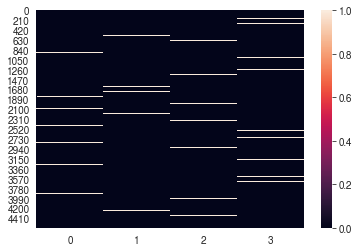

In [91]:
ax = sns.heatmap(x['taskDesignMat'][:,ind])

In [46]:
roi_ind = np.where(glasser2==8)[0]

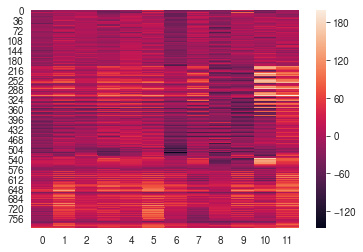

In [92]:
sns.heatmap(data_task[roi_ind,:,3])

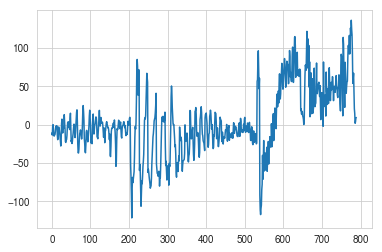

In [93]:
plt.plot(data_task[roi_ind,9,20])

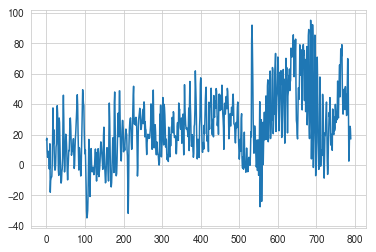

In [94]:
plt.plot(data_task[roi_ind,11,30])

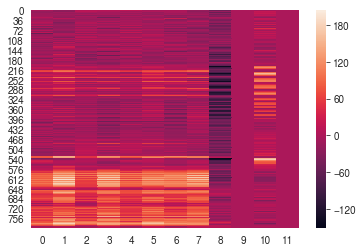

In [55]:
sns.heatmap(data_task[roi_ind,:,20])

In [82]:
# gsr = True
nStims = 12
data_task = np.zeros((len(glasser2),nStims,len(subjNums)))
rules = ['Logic','Sensory','Motor']

scount = 0
for subj in subjNums:
    rulecount = 0
    for rule in rules:
        data_task[:,rulecount:(rulecount+4),scount] = tools_group.loadInputActivity(subj,rule)
        rulecount += 4
    scount += 1

/home/tito/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  # Remove the CWD from sys.path while we load stuff.


#### Run decoding 

In [85]:
tools_group = reload(tools_group)
nproc = 30
ncvs = 1
# rois = []
# rois.extend(np.where(networkdef==networkmappings['fpn'])[0])
# rois.extend(np.where(networkdef==networkmappings['con'])[0])
# rois.extend(np.where(networkdef==networkmappings['dan'])[0])

rois = np.arange(nParcels)

distances_baseline_allrules, rmatch, rmismatch, confusion_mats = tools_group.conditionDecodings(data_task, rois, motorOutput=False, ncvs=ncvs, effects=True, confusion=True, nproc=nproc)

#### Compute statistics

In [95]:
# rule = 'Logic'
statistics_allrules = np.zeros((len(rois),3)) # acc, q, acc_thresh
for roicount in range(len(rois)):
    ntrials = distances_baseline_allrules.shape[1]
    p = stats.binom_test(np.mean(distances_baseline_allrules[roicount,:])*ntrials,n=ntrials,p=1/float(nStims))
    if np.mean(distances_baseline_allrules[roicount,:])>1/float(nStims):
        p = p/2.0
    else:
        p = 1.0-p/2.0
        

    statistics_allrules[roicount,0] = np.mean(distances_baseline_allrules[roicount,:])
    statistics_allrules[roicount,1] = p

h0, qs = mc.fdrcorrection0(statistics_allrules[:,1])
for roicount in range(len(rois)):
    statistics_allrules[roicount,1] = qs[roicount]
    statistics_allrules[roicount,2] = h0[roicount]*statistics_allrules[roicount,0]
    
# Count number of significant ROIs for LH decoding
sig_ind = np.where(statistics_allrules[:,1]<0.05)[0]
print 'Number of ROIs significant for all 12 rules:', sig_ind.shape[0]
print 'Accuracies:', statistics_allrules[sig_ind,0]

#### Map back to surface
# Put all data into a single matrix (since we only run a single classification)
inputStim = np.zeros((glasser2.shape[0],3))

roicount = 0
for roi in rois:
    vertex_ind = np.where(glasser2==roi+1)[0]
    inputStim[vertex_ind,0] = statistics_allrules[roicount,0]
    inputStim[vertex_ind,1] = statistics_allrules[roicount,1]
    inputStim[vertex_ind,2] = statistics_allrules[roicount,2]

    roicount += 1

np.savetxt('/projects3/SRActFlow/data/results/GroupfMRI/RuleDecoding/12Rule_Regions.csv', np.where(statistics_allrules[:,1]<0.05)[0], delimiter=',')
    
#### 
# Write file to csv and run wb_command
outdir = '/projects3/SRActFlow/data/results/GroupfMRI/RuleDecoding/'
filename = '12RuleDecoding'
np.savetxt(outdir + filename + '.csv', inputStim,fmt='%s')
wb_file = filename + '.dscalar.nii'
wb_command = 'wb_command -cifti-convert -from-text ' + outdir + filename + '.csv ' + glasserfile2 + ' ' + outdir + wb_file + ' -reset-scalars'
os.system(wb_command)


Number of ROIs significant for all 12 rules: 229
Accuracies: [0.15885417 0.15017361 0.14930556 0.1484375  0.25       0.22395833
 0.15538194 0.12934028 0.12934028 0.11111111 0.13194444 0.11979167
 0.13454861 0.11284722 0.1015625  0.109375   0.11371528 0.12760417
 0.11892361 0.11631944 0.10243056 0.11805556 0.10590278 0.11111111
 0.1015625  0.13368056 0.12152778 0.12152778 0.19357639 0.17013889
 0.14149306 0.13715278 0.13107639 0.12065972 0.2109375  0.17621528
 0.20138889 0.16753472 0.11024306 0.13802083 0.10590278 0.10416667
 0.12239583 0.12239583 0.1015625  0.13368056 0.12065972 0.09895833
 0.1171875  0.12413194 0.09982639 0.09982639 0.11284722 0.11371528
 0.11284722 0.11805556 0.12934028 0.15190972 0.10590278 0.11197917
 0.11197917 0.13020833 0.12239583 0.09982639 0.10416667 0.09895833
 0.1015625  0.11458333 0.18315972 0.11545139 0.13802083 0.10243056
 0.12586806 0.12413194 0.12152778 0.10329861 0.14149306 0.12760417
 0.11371528 0.13454861 0.12934028 0.12847222 0.10763889 0.10677083
 

0

In [96]:
statistics_allrules[8]

array([2.23958333e-01, 2.85263234e-46, 2.23958333e-01])

In [97]:
confusion_mats[169]

array([[0.        , 0.01041667, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.01041667, 0.        ],
       [0.01041667, 0.02083333, 0.01041667, 0.01041667, 0.        ,
        0.01041667, 0.01041667, 0.01041667, 0.01041667, 0.01041667,
        0.05208333, 0.        ],
       [0.02083333, 0.        , 0.01041667, 0.        , 0.02083333,
        0.01041667, 0.02083333, 0.03125   , 0.03125   , 0.01041667,
        0.02083333, 0.04166667],
       [0.01041667, 0.        , 0.01041667, 0.01041667, 0.        ,
        0.        , 0.        , 0.01041667, 0.        , 0.        ,
        0.        , 0.        ],
       [0.        , 0.        , 0.01041667, 0.01041667, 0.01041667,
        0.03125   , 0.        , 0.02083333, 0.01041667, 0.01041667,
        0.        , 0.        ],
       [0.02083333, 0.01041667, 0.        , 0.01041667, 0.05208333,
        0.        , 0.02083333, 0.01041667, 0.01041667, 0.        ,
        0.        ,

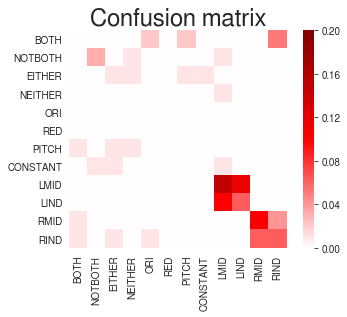

In [103]:
ax = sns.heatmap(confusion_mats[7],center=0,vmax=.2,square=True,cmap='seismic')
plt.title('Confusion matrix',fontsize=24)
plt.xticks(np.arange(0.5,12.5),['BOTH','NOTBOTH','EITHER','NEITHER','ORI','RED','PITCH','CONSTANT','LMID','LIND','RMID','RIND'],rotation=90);
plt.yticks(np.arange(0.5,12.5),['BOTH','NOTBOTH','EITHER','NEITHER','ORI','RED','PITCH','CONSTANT','LMID','LIND','RMID','RIND'],rotation=0);


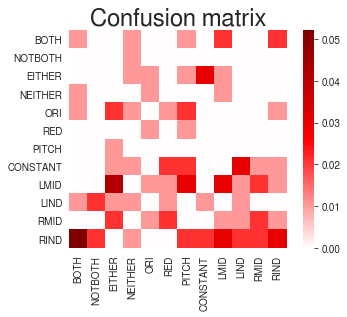

In [105]:
ax = sns.heatmap(confusion_mats[186],center=0,square=True,cmap='seismic')
plt.title('Confusion matrix',fontsize=24)
plt.xticks(np.arange(0.5,12.5),['BOTH','NOTBOTH','EITHER','NEITHER','ORI','RED','PITCH','CONSTANT','LMID','LIND','RMID','RIND'],rotation=90);
plt.yticks(np.arange(0.5,12.5),['BOTH','NOTBOTH','EITHER','NEITHER','ORI','RED','PITCH','CONSTANT','LMID','LIND','RMID','RIND'],rotation=0);